In [1]:
#Activate the virtual environment
!.\.venv\Scripts\activate.bat
#Dependencies 
! pip install -r requirements.txt
!python -m ipykernel install --user --name=Gym-RL


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Installed kernelspec Gym-RL in C:\Users\Joseph\AppData\Roaming\jupyter\kernels\gym-rl


In [2]:
import numpy as np
import gymnasium as gym
import torch

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
# The "ipympl" backend is better, as it allows for interactiveness, but on some installations it does not work, then use "inline"
%matplotlib ipympl
# %matplotlib inline  

# this way of importing allow to reload/refresh the module later with importlib.reload(policy)
import policy as policy 
import memory as mem
from feedforward import Feedforward

Load environment, policy and memory.

In [3]:
env = gym.make('Pendulum-v1', g=9.81, render_mode="human")
pi = policy.PDPolicy(env)
buffer = mem.Memory()

## Inspect the environment 

In [4]:
s , _ = env.reset()
for t in range(100):
    a = pi.get_action(s) 
    s_new, rew, term, trunc, _ = env.step(a)
    buffer.add_transition([s,a,rew,s_new, term, trunc])
    s = s_new

In [ ]:
transitions = buffer.get_all_transitions()
states = np.vstack(transitions[:,0])
actions = transitions[:,1]
rewards = transitions[:,2]

### 3a)

Plot the trajectory: (state, action, reward)
 
 The state is [position, velocity] 
 
 **changes are needed**

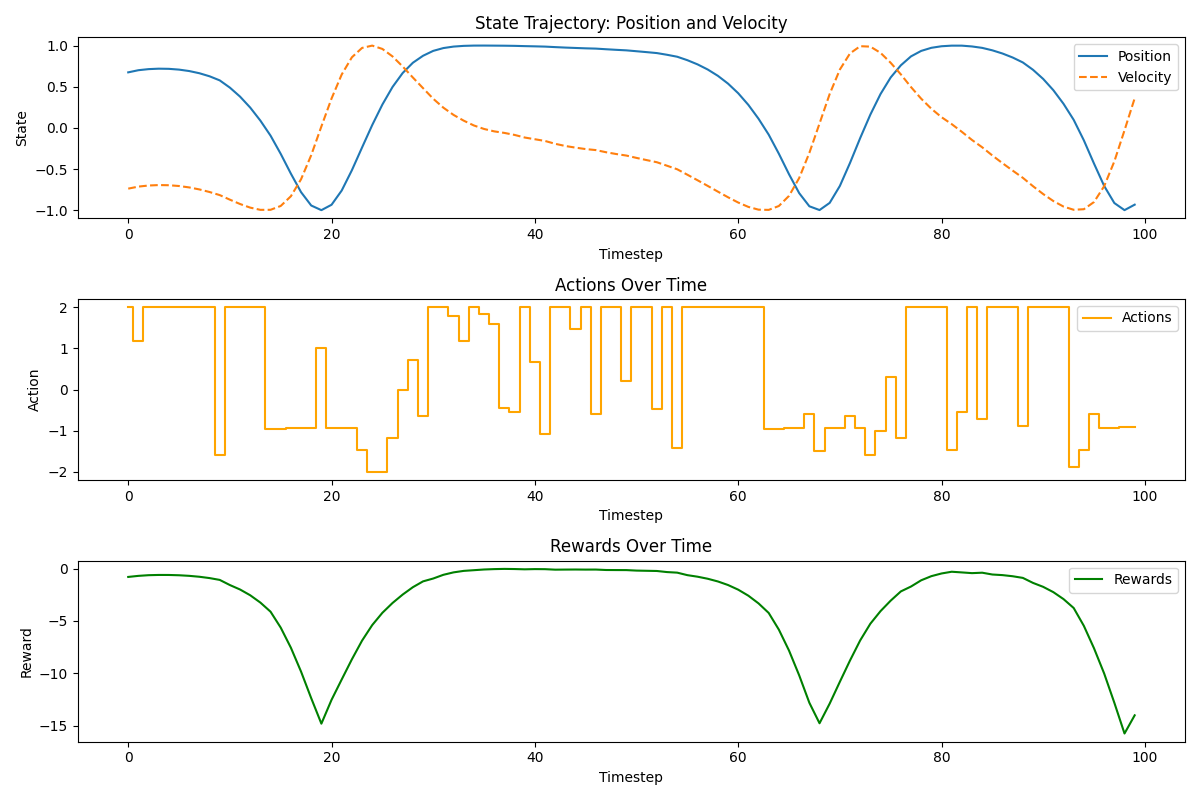

In [6]:
# Assuming `states`, `actions`, and `rewards` are already extracted
positions = states[:, 0]  # Extract position
velocities = states[:, 1]  # Extract velocity

# Create the figure and subplots
plt.figure(figsize=(12, 8))

# Plot positions over time
plt.subplot(3, 1, 1)
plt.plot(positions, label='Position')
plt.plot(velocities, label='Velocity', linestyle='--')
plt.title('State Trajectory: Position and Velocity')
plt.xlabel('Timestep')
plt.ylabel('State')
plt.legend()

# Plot actions over time
plt.subplot(3, 1, 2)
plt.step(range(len(actions)), actions, where='mid', label='Actions', color='orange')
plt.title('Actions Over Time')
plt.xlabel('Timestep')
plt.ylabel('Action')
plt.legend()

# Plot rewards over time
plt.subplot(3, 1, 3)
plt.plot(rewards, label='Rewards', color='green')
plt.title('Rewards Over Time')
plt.xlabel('Timestep')
plt.ylabel('Reward')
plt.legend()

plt.tight_layout()
plt.show()


# Collect data

We do 500 rollouts a 100 timesteps with the black box policy. Nothing needs to be changed here.

In [7]:
env = gym.make('Pendulum-v1', g=9.81, render_mode=None) # switch off rendering
for ep in range(500):
    # start a larger range initial conditions to see enough of the statespace
    s, _ = env.reset(options={"y_init": 4.0})
    for t in range(100):
        a = pi.get_action(s) 
        s_new, rew, term, trunc, _ = env.step(a)
        buffer.add_transition([s,a,rew,s_new, term, trunc])
        s = s_new

In [8]:
buffer.size

50100

# Fit value function
### 3b)

The value function fitting class. Here, you need to fill in the blank parts

In [9]:
class ValueFunction(Feedforward):
    def __init__(self, observation_dim, hidden_sizes=[100,100]):
        super().__init__(input_size=observation_dim, hidden_sizes=hidden_sizes, output_size=1)
        
        # so this class is already a neural network, see feedforward.py        
        # add and optimizer here (e.g. Adam with lr = 0.0002, eps=0.000001)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0002, eps=0.000001)
        
        # add a loss function here
        self.loss = torch.nn.MSELoss()
    
    def fit(self, observations, targets):
        # Add one training step here. 
        # The states are called here observations
        # The targets are the returns from the states
        # convert the inputs into torch tensors with torch.from_numpy
        observations = torch.from_numpy(observations).float()
        targets = torch.from_numpy(targets).float()
       
        # use self.forward(input) to make a prediction to be used in the loss
        # Forward pass
        outputs = self.forward(observations)

        # Compute the loss
        loss = self.loss(outputs, targets)

        # Backward pass (Backpropagation)
        self.optimizer.zero_grad()
        # Compute the gradients
        loss.backward()
        # Update the parameters
        self.optimizer.step()

        
        # Hints:         
        
        # return the current loss
        return loss.item()

In [20]:
np.random.seed(1234)
valuefunc = ValueFunction(observation_dim=env.observation_space.shape[0])
valuefunc2 = ValueFunction(observation_dim=env.observation_space.shape[0])
valuefunc3 = ValueFunction(observation_dim=env.observation_space.shape[0])

Fitting routine of the value function. Fill in the blank parts.

Appropiate target: Temporal difference update for the value fitting with $\gamma = 0.95$
Monitor the learning progress

In [21]:
plt_fit = []

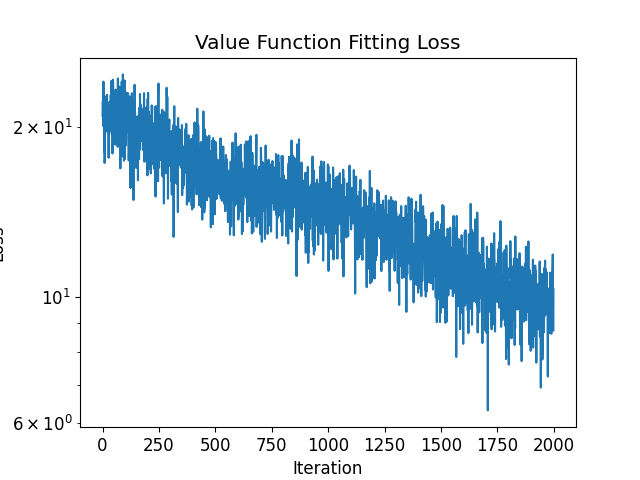

In [22]:
# set seed
np.random.seed(1234)

iter_fit = 2000 # do at least 2000
gamma=0.95
for i in range(iter_fit):

    # sample from the replay buffer
    data=buffer.sample(batch=512) # We do it by batches instad of individually
    # each entry in data is (state,action,reward,next_state, term, trunc)    
    
    # Hints:
    #  use can use np.stack to convert the array or arrays into one array
    #  it is really important that you check the shapes of your arrays.
    #  It should be (128,2) for the state and (128,1) for reward and values
    
    states = np.stack(data[:,0])
    actions = np.stack(data[:,1])
    rewards = np.stack(data[:,2]).reshape(-1, 1)
    next_states = np.stack(data[:,3])
    terms = np.stack(data[:,4]).reshape(-1, 1)
    truncs = np.stack(data[:,5])

    # Predict the value of the next state
    next_states_tensor = torch.from_numpy(next_states).float()  # Convert NumPy array to PyTorch tensor
    next_state_values = valuefunc.forward(next_states_tensor).squeeze().detach().numpy()  # Perform forward pass
    next_state_values = next_state_values.reshape(-1, 1)
    next_state_values[terms == 1] = 0.0 # if the next state is terminal, the value is 0

    # Compute TD target
    td_target = rewards + gamma * next_state_values # Bellman equation
    
    # optimize the least squared objective
    fit_loss = valuefunc.fit(states, td_target)
    
    plt_fit.append(fit_loss)
    
# plot the loss
plt.figure()
plt.yscale("log")
plt.plot(range(len(plt_fit)),plt_fit)
plt.title("Value Function Fitting Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

The loss plot shows a slowly decreasing trend, although with high noise, indicating that the neural network is successfully learning the value function through TD updates steadily but allowing for high deviance from the main trend. The fluctuations are likely due to the small learning rate and high discount factor allowing for a big amount of exploration

# Visualize

Visualization of the value function. Nothing needs to be changed here.

In [23]:
def plot_value_function(value_function):
    plt.rcParams.update({'font.size': 12})
    xxs =np.linspace(-np.pi/2,np.pi/2)
    yys =np.linspace(-3,3)
    XX,YY=np.meshgrid(xxs,yys)
    dots=np.asarray([np.cos(XX.ravel()),np.sin(XX.ravel()),YY.ravel()]).T
    print(dots.shape)
    # values = np.asarray(test_func(dots)).reshape(XX.shape)
    values =value_function.predict(dots).reshape(XX.shape)

    fig = plt.figure(figsize=[10,8])
    ax = fig.add_subplot(projection='3d')
    surf = ax.plot_surface(XX, YY, values, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    ax.view_init(elev=30, azim=45, roll=0)
    ax.set_xlabel('angle')
    ax.set_ylabel('angle velocity')
    ax.set_zlabel('value')
    # plt.colorbar(cmap=cm.coolwarm)
    return fig

### 3c) Plot the value function before and after learning

(2500, 3)


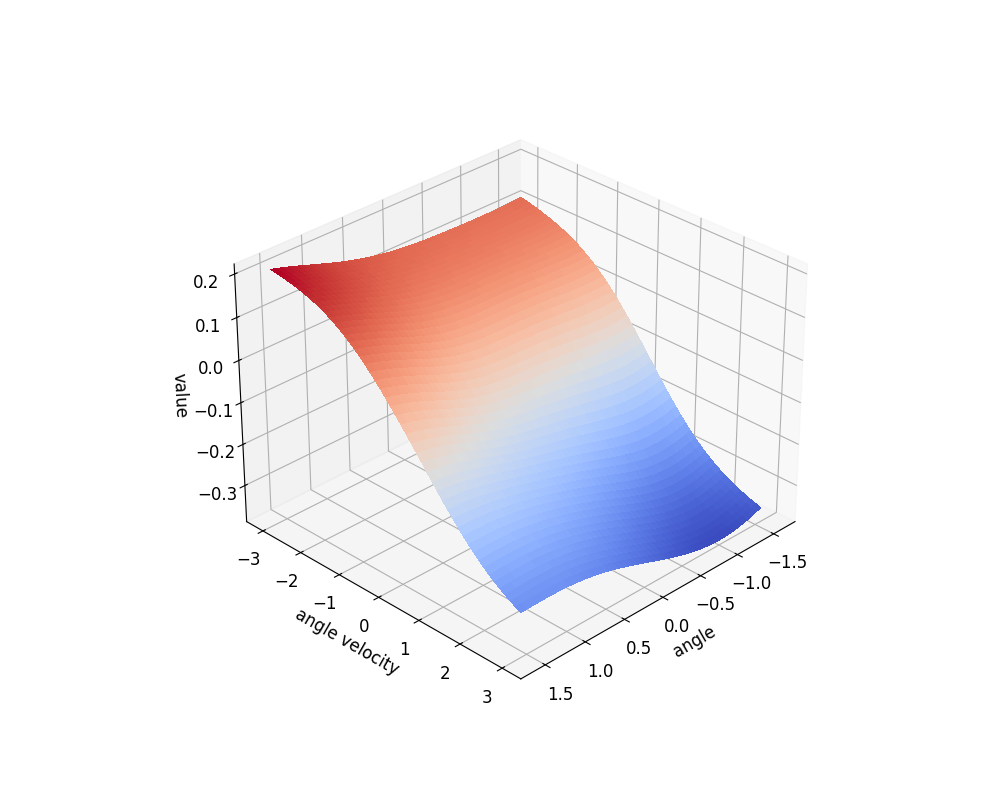

In [24]:
fig = plot_value_function(valuefunc2)
fig.savefig("value_approx_before.pdf", bbox_inches="tight")

### And now the one after training

(2500, 3)


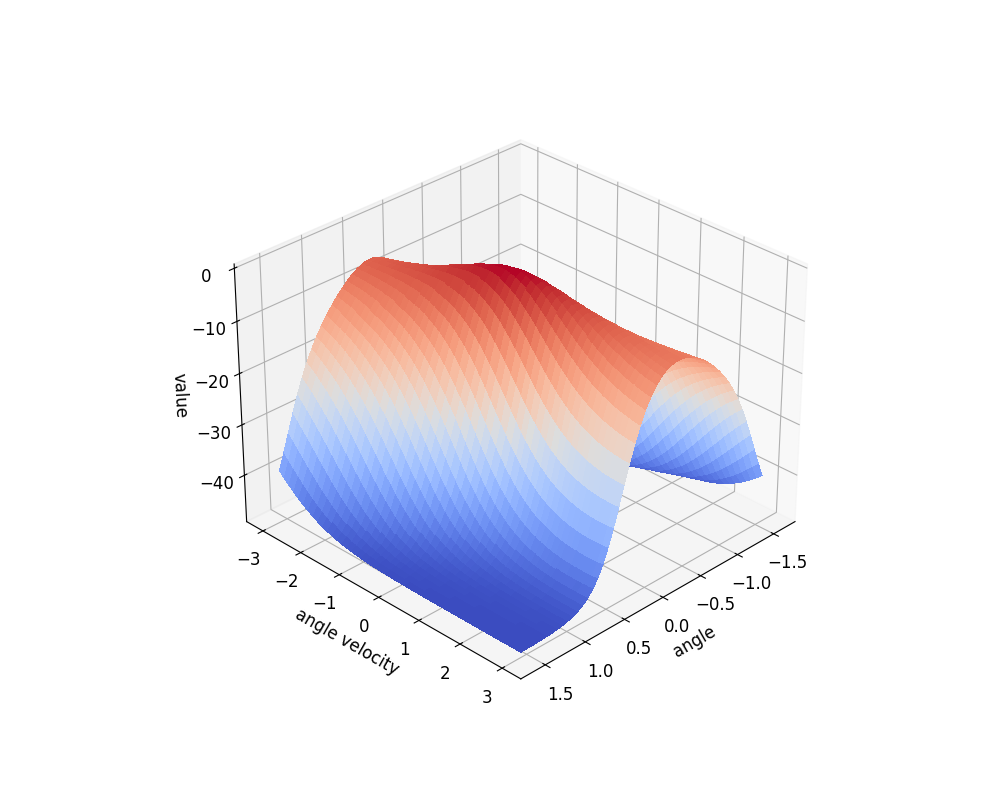

In [25]:
fig = plot_value_function(valuefunc)
fig.savefig("value_approx.pdf", bbox_inches="tight")

### 3d) Give an intuitive interpretation of the plotted value function.

Before learning, the value function is a flat plane surface, with minimal variability because the network doesn't know yet which states are valuable. It only predicts value as a linear function of one of the independent variables.
After learning, the value function shows significant structure, with peaks and lows where higher values (red) correspond to more favorable states and lower values (blue) represent less favorable states. Now the value is a function of both of angle and angle velocity. The peak makes sense because it represents when the pendulum is at the top which coincides which it not moving fast because it's pointing upwards


### 3e) Compare the learning curve and the resulting value function when using γ = 0.5. What happens?


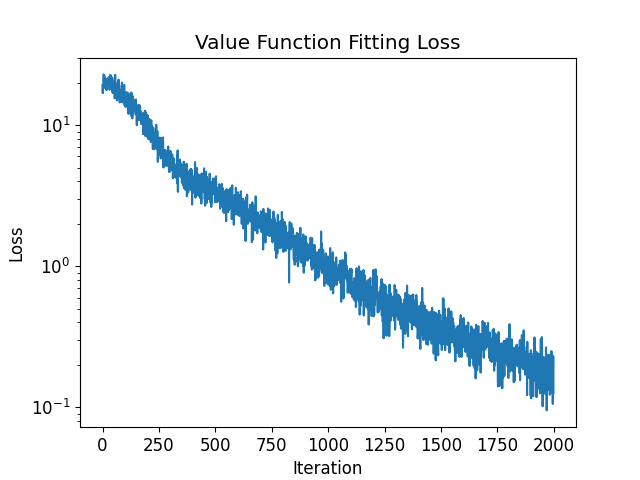

In [26]:
plt_fit2 = []

iter_fit = 2000 # do at least 2000
gamma=0.50
for i in range(iter_fit):

    # sample from the replay buffer
    data=buffer.sample(batch=512) # We do it by batches instad of individually
    # each entry in data is (state,action,reward,next_state, term, trunc)    
    
    # Hints:
    #  use can use np.stack to convert the array or arrays into one array
    #  it is really important that you check the shapes of your arrays.
    #  It should be (128,2) for the state and (128,1) for reward and values
    
    states = np.stack(data[:,0])
    actions = np.stack(data[:,1])
    rewards = np.stack(data[:,2]).reshape(-1, 1)
    next_states = np.stack(data[:,3])
    terms = np.stack(data[:,4]).reshape(-1, 1)
    truncs = np.stack(data[:,5])

    # Predict the value of the next state
    next_states_tensor = torch.from_numpy(next_states).float()  # Convert NumPy array to PyTorch tensor
    next_state_values = valuefunc3.forward(next_states_tensor).squeeze().detach().numpy()  # Perform forward pass
    next_state_values = next_state_values.reshape(-1, 1)
    next_state_values[terms == 1] = 0.0 # if the next state is terminal, the value is 0

    # Compute TD target
    td_target = rewards + gamma * next_state_values # Bellman equation
    
    # optimize the least squared objective
    fit_loss = valuefunc3.fit(states, td_target)
    
    plt_fit2.append(fit_loss)
    
# plot the loss
plt.figure()
plt.yscale("log")
plt.plot(range(len(plt_fit2)),plt_fit2)
plt.title("Value Function Fitting Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

(2500, 3)


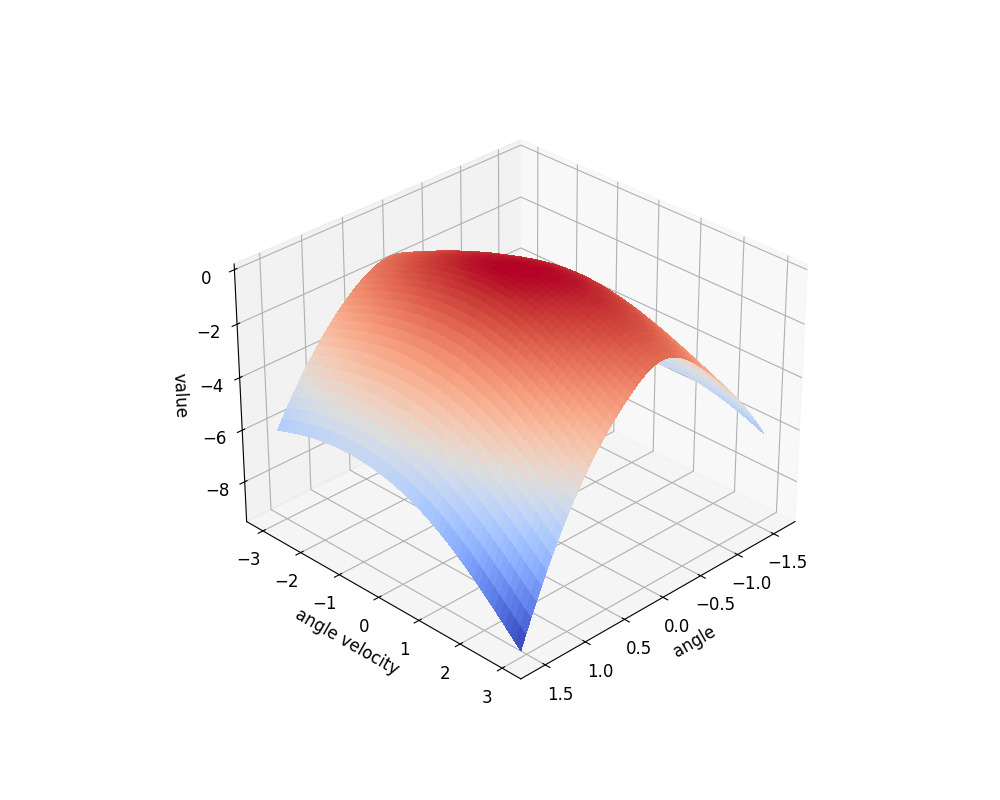

In [27]:
fig = plot_value_function(valuefunc3)
fig.savefig("value_approx_gamma05.pdf", bbox_inches="tight")

The loss reduction is still showing a steady decreasing trend. However we don't see so much variability as before given that the algorithm is looking for more short term returns and therefore choosing the safe way out instead of "exploring" for other possible long term advantageous options. 
On the other hand, we find that the value function is smoother than in the first case, meaning that we have a less nuanced model. However, apart from this, an in particular the peak that we observe in the first figure, both models looks very similar to each other